## 5. 端到端案例：迷你销售分析报告


现在，是时候将我们前面学到的所有知识——NumPy 的计算、Pandas 的数据处理和 Matplotlib 的可视化——串联起来，解决一个真实的（尽管是简化的）商业问题了。本章将带你走完一个从原始数据到最终洞察的完整流程。


本章，你将实践：


- **定义问题**: 将一个模糊的业务需求转化为清晰的数据分析目标。


- **数据准备**: 加载、清洗（处理重复值）、转换和特征工程。


- **深度聚合分析**: 使用 `groupby` 和 `agg` 从数据中提取多维度关键指标。


- **结果呈现**: 用合适的图表（如子图仪表盘）将分析结果可视化，并得出结论。

---


### 场景：线上零售店的月度复盘


**业务背景**: 假设你是一家小型线上零售店的数据分析师。老板想了解第一季度的整体销售情况，并找出哪些产品类别和具体产品最受欢迎，以便为下一个季度的备货和营销活动提供数据支持。


**分析目标**: 


1.  计算并展示每月的总销售额趋势。


2.  分析各产品类别的销售表现（从销售额、销量和订单数三个维度）。


3.  找出总销售额最高的 Top 3 产品是什么。




这个流程体现了数据分析的核心循环：**加载数据 → 清洗与准备 → 分析与聚合 → 可视化与解读**。

> 📌 **提示**：本章的可视化仪表盘图片可通过命令 `python codes/generate_toy_case_images.py` 自动生成，输出会保存到 `images/toy-case/` 目录。

### 准备工作


和之前一样，我们首先需要导入三大核心库，并设置 Matplotlib 的绘图样式。

In [1]:
import numpy as np


import pandas as pd


import matplotlib.pyplot as plt




plt.style.use("seaborn-v0_8-whitegrid")


plt.rcParams["axes.unicode_minus"] = False

### 第一步：加载与清洗数据 (Pandas)


为了让案例更真实，我们的模拟数据包含了一些“不干净”的成分，比如重复的行。在分析之前，必须先将它们处理掉。

In [2]:
data = {
    "OrderID": [
        "O001",
        "O002",
        "O003",
        "O004",
        "O005",
        "O006",
        "O007",
        "O008",
        "O009",
        "O010",
        "O011",
        "O012",
        "O013",
        "O014",
        "O014",
    ],
    "Date": [
        "2023-01-15",
        "2023-01-20",
        "2023-02-05",
        "2023-02-12",
        "2023-02-21",
        "2023-03-04",
        "2023-03-10",
        "2023-03-18",
        "2023-03-25",
        "2023-01-28",
        "2023-02-15",
        "2023-03-22",
        "2023-01-25",
        "2023-03-30",
        "2023-03-30",
    ],
    "Category": [
        "电子产品",
        "家居用品",
        "电子产品",
        "图书",
        "家居用品",
        "电子产品",
        "图书",
        "电子产品",
        "家居用品",
        "图书",
        "图书",
        "家居用品",
        "电子产品",
        "电子产品",
        "电子产品",
    ],
    "Product": [
        "笔记本电脑",
        "咖啡机",
        "无线鼠标",
        "数据分析入门",
        "智能台灯",
        "键盘",
        "Python编程",
        "显示器",
        "储物盒",
        "机器学习实战",
        "Web开发",
        "香薰机",
        "游戏手柄",
        "充电宝",
        "充电宝",
    ],
    "Price": [
        7000,
        800,
        150,
        60,
        200,
        450,
        70,
        2000,
        80,
        80,
        55,
        150,
        300,
        120,
        120,
    ],
    "Quantity": [1, 2, 5, 10, 3, 2, 8, 1, 15, 6, 9, 2, 2, 1, 1],
}

sales_df = pd.DataFrame(data)

print(f"清洗前的数据行数: {len(sales_df)}")
duplicate_count = sales_df.duplicated().sum()
print(f"存在 {duplicate_count} 个完全重复的行。")

sales_df = sales_df.drop_duplicates().reset_index(drop=True)
print(f"清洗后的数据行数: {len(sales_df)}")

sales_df["Date"] = pd.to_datetime(sales_df["Date"])  # 转换日期
sales_df["Month"] = sales_df["Date"].dt.month
sales_df["TotalSale"] = sales_df["Price"] * sales_df["Quantity"]

print("\n--- 清洗和准备后的数据预览 ---")
sales_df.head()

清洗前的数据行数: 15
存在 1 个完全重复的行。
清洗后的数据行数: 14

--- 清洗和准备后的数据预览 ---


,OrderID,Date,Category,Product,Price,Quantity,Month,TotalSale
0,O001,2023-01-15,电子产品,笔记本电脑,7000,1,1,7000
1,O002,2023-01-20,家居用品,咖啡机,800,2,1,1600
2,O003,2023-02-05,电子产品,无线鼠标,150,5,2,750
3,O004,2023-02-12,图书,数据分析入门,60,10,2,600
4,O005,2023-02-21,家居用品,智能台灯,200,3,2,600


### 第二步：聚合与深度分析 (Pandas `groupby` & `agg`)


数据干净后，我们就可以开始回答业务问题了。这次我们使用 `.agg()` 方法，它可以同时计算多个聚合指标，让分析更高效、更全面。

#### 分析 1：计算月度销售总额

In [3]:
monthly_sales = sales_df.groupby("Month", as_index=False)["TotalSale"].sum()
month_map = {1: "一月", 2: "二月", 3: "三月"}
monthly_sales["MonthName"] = monthly_sales["Month"].map(month_map)
monthly_sales = monthly_sales.sort_values("Month").reset_index(drop=True)

print("--- 月度销售总额 ---")
monthly_sales

--- 月度销售总额 ---


,Month,TotalSale,MonthName
0,1,9680,一月
1,2,2445,二月
2,3,5080,三月


#### 分析 2：计算各类别多维度表现


一个品类是否“好”，不能只看销售额。我们还应该关注它的总销量和订单数，这能提供更丰富的视角。

In [4]:
category_analysis = (
    sales_df.groupby("Category")
    .agg(
        TotalRevenue=("TotalSale", "sum"),
        TotalQuantity=("Quantity", "sum"),
        OrderCount=("OrderID", "nunique"),
    )
    .sort_values(by="TotalRevenue", ascending=False)
)

print("\n--- 各类别销售表现 ---")
category_analysis


--- 各类别销售表现 ---


,TotalRevenue,TotalQuantity,OrderCount
Category,,,
电子产品,11370,12,6
家居用品,3700,22,4
图书,2135,33,4


#### 分析 3：找出最畅销的产品


在品类之下，具体是哪个产品最受欢迎？这对于精准备货至关重要。

In [5]:
product_sales = sales_df.groupby("Product")["TotalSale"].sum().sort_values(ascending=False)
top_3_products = product_sales.head(3)

print("\n--- 销售额 Top 3 产品 ---")
top_3_products


--- 销售额 Top 3 产品 ---


Product
笔记本电脑    7000
显示器      2000
咖啡机      1600
Name: TotalSale, dtype: int64

### 第三步：可视化呈现 (Matplotlib)


我们将上面的分析结果用一个简洁的“仪表盘”展示出来。下方的代码会生成三个子图：月度趋势、品类对比和 Top 3 畅销产品。实际用于文档的静态图片由 `codes/generate_toy_case_images.py` 脚本生成。

C:\Users\LADH\AppData\Local\Temp\ipykernel_21116\1517071048.py:42: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  fig.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\LADH\AppData\Local\Temp\ipykernel_21116\1517071048.py:42: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\LADH\AppData\Local\Temp\ipykernel_21116\1517071048.py:42: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from current font.
  fig.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\LADH\AppData\Local\Temp\ipykernel_21116\1517071048.py:42: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\LADH\AppData\Local\Temp\ipykernel_21116\1517071048.py:42: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from current font.
  fig.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\LADH\AppData\Local\Temp\ip

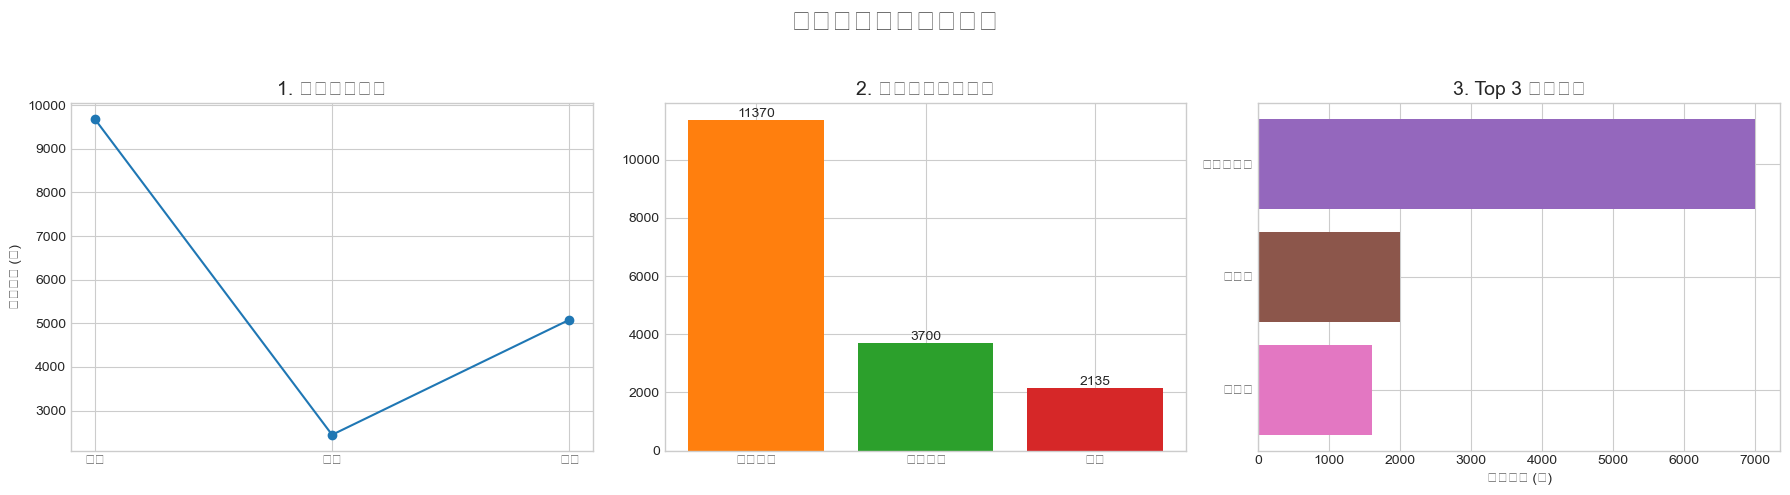

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 月度销售趋势
axes[0].plot(
    monthly_sales["MonthName"],
    monthly_sales["TotalSale"],
    marker="o",
    linestyle="-",
    color="#1f77b4",
)
axes[0].set_title("1. 月度销售趋势", fontsize=14)
axes[0].set_ylabel("总销售额 (元)")

# 各类别销售额
bars = axes[1].bar(
    category_analysis.index,
    category_analysis["TotalRevenue"],
    color=["#ff7f0e", "#2ca02c", "#d62728"],
)
axes[1].set_title("2. 各类别销售额对比", fontsize=14)
for bar in bars:
    yval = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2.0,
        yval,
        f"{int(yval)}",
        va="bottom",
        ha="center",
    )

# Top 3 畅销产品
axes[2].barh(
    top_3_products.index,
    top_3_products.values,
    color=["#9467bd", "#8c564b", "#e377c2"],
)
axes[2].set_title("3. Top 3 畅销产品", fontsize=14)
axes[2].invert_yaxis()
axes[2].set_xlabel("总销售额 (元)")

fig.suptitle("第一季度销售分析报告", fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 第四步：结论与洞察


根据我们的深度分析和可视化结果，我们可以向老板汇报：


1.  **销售趋势**：第一季度的销售额在二月份达到顶峰，一月和三月较为平稳。二月的增长值得深入研究。


2.  **品类表现**：“电子产品”是绝对的销售主力，贡献了超过 80% 的销售额。然而，从订单数量上看，“家居用品”和“图书”的订单数并不少，说明它们虽然单价低，但依然有稳定的客户群。


3.  **明星产品**：在所有产品中，“笔记本电脑”以 7000 元的销售额一骑绝尘，是核心中的核心。“显示器”和“咖啡机”紧随其后，是第二梯队的重要产品。




**建议**：


- **核心业务**：必须保证“笔记本电脑”和“显示器”等高价值电子产品的库存，它们是收入的基石。


- **潜力挖掘**：可以考虑对“家居用品”和“图书”品类进行捆绑销售或促销活动，以提高这两个品类的客单价。


- **精准营销**：针对“咖啡机”这类热销单品，可以开展精准的营销推广。




---


**实践小结**: 恭喜你！你已经成功地走完了一个更真实、更深入的数据分析流程。这个案例展示了如何通过数据清洗保证分析质量，如何通过多维度聚合获得更深刻的洞察，以及如何通过组合图表讲述一个完整的数据故事。这是数据分析工作的核心价值所在。接下来的章节，我们将为你提供一些常见问题的解决方案、学习资源和后续的练习建议。